# Draft: AuxTel Pointing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm

from astropy.table import Table, join

In [2]:
%matplotlib inline


## The Dataset

This sample was queried using the script `query_pointing_bluter.py`. Basically, the code query the WCS solution from the bulter calibrate task and some information from the exposure metadata.

The main quantities of this dataset are:
- `RA`, `DEC` : pointing sky position from the exposure metadata
- `RA_WCS`, `DEC_WCS` : pointing sky position from the wcs solutions
- `PNT_OFFSET`: angular distance between the two pointings.

The other columns are exclusively from the metadata: `MJD`,`EXPTIME`,`TEMP_SET`,`CCDTEMP`,`FILTER`,`ELSTART`,`ELEND`,`AZSTART`,`AZEND`

The file `data/checking_auxtel_pointing_{date}.csv` contains info about 1421 exposures taken from Feb 2020 up to Nov 2021. The collection used to generate this file was `u/mfl/testProcessCcd_srcMatchFull_181e6356`. And it's from the `lsst.rapid.analysis.butlerUtils`.



# The Telescope Pointing

In [3]:
import pandas as pd
date = 23032022
# df = pd.read_csv(f'data/checking_auxtel_pointing_{date}.csv',index_col=0)

df = pd.read_csv('data/rev_checking_auxtel_pointing_24032022.csv',index_col=0)
# df = pd.read_csv('data/test_checking_auxtel_pointing_23032022.csv',index_col=0)

df.DATE = pd.to_datetime(df.DATE)#.dt.date

In [4]:
import numpy as np

deg = np.pi/180.
def separation(ra1,dec1,ra2,dec2):
    return np.sqrt( np.cos(dec1*deg)*(ra1-ra2)**2 + (dec1-dec2)**2 )*3600.

def getAngDist(ra1, dec1, ra2, dec2):
    # output in arcmin
    delt_lon = (ra1 - ra2)*np.pi/180.
    delt_lat = (dec1 - dec2)*np.pi/180.
    # Haversine formula
    dist = 2.0*np.arcsin( np.sqrt( np.sin(delt_lat/2.0)**2 + \
         np.cos(dec1*np.pi/180.)*np.cos(dec2*np.pi/180.)*np.sin(delt_lon/2.0)**2 ) )  
    return (dist/np.pi*180.)*60

In [5]:
# df['AZMEAN'] = 0.5*(df['AZEND']+df['AZSTART'])
# df['ELMEAN'] = 0.5*(df['ELEND']+df['ELSTART'])

# df['dRA'] = (df['RA_WCS']-df['RA'])*60
# df['dDEC']= (df['DEC_WCS']-df['DEC'])*60

# df['PNT_OFFSET'] = getAngDist(df['RA_WCS'], df['DEC_WCS'], df['RA'], df['DEC'])

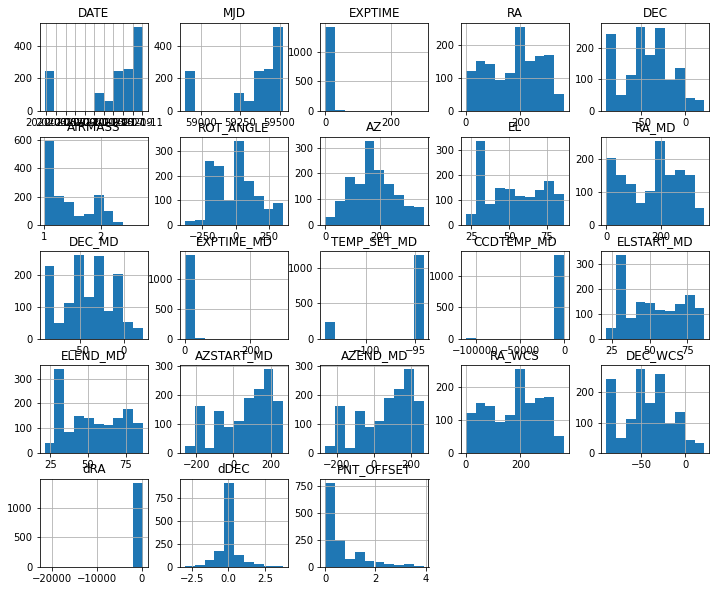

In [6]:
_ = df.hist(figsize=(12,10))

In [7]:
# outliers = np.abs(df['PNT_OFFSET'])>60
outliers = np.abs(df['dRA'])>2*3600
df[outliers]

,DATE,MJD,EXPTIME,RA,DEC,AIRMASS,ROT_ANGLE,AZ,EL,RA_MD,...,FILTER_MD,ELSTART_MD,ELEND_MD,AZSTART_MD,AZEND_MD,RA_WCS,DEC_WCS,dRA,dDEC,PNT_OFFSET
2021110400400,2021-11-05 03:31:58.846693,59523.147209,30.0,0.025367,-89.896757,1.964636,359.990442,180.048559,30.507803,0.0,...,SDSSg,30.507803,30.507567,180.048559,180.049145,359.663974,-89.89534,-21578.316413,-0.085006,0.093668


In [8]:
df[['RA','RA_WCS','dRA']][outliers]

,RA,RA_WCS,dRA
2021110400400,0.025367,359.663974,-21578.316413


Note: suggest to DM to add a mod(ra1-ra2, 360) into their offset function (dRa, dDec, ...).

In [9]:
21578.316413/60.

359.63860688333335

In [10]:
(360-21578.316413/60.) # this should be dRA (deg)

0.36139311666664753

## Subsample

In [11]:
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]

df1 = df[cols][~outliers]
# df1['DATE'] = df1['DATE'].dt.date

In [12]:
df1

,PNT_OFFSET,DATE,MJD,EXPTIME,RA,DEC,AIRMASS,ROT_ANGLE,AZ,EL,...,CCDTEMP_MD,FILTER_MD,ELSTART_MD,ELEND_MD,AZSTART_MD,AZEND_MD,RA_WCS,DEC_WCS,dRA,dDEC
2020021700328,0.541438,2020-02-18 04:08:26.981500,58897.172535,5.0,144.696586,-60.091873,1.156347,37.450522,173.810313,59.859032,...,-100.805046,empty_3,59.859032,59.862084,173.810313,173.842712,144.702793,-60.083396,-0.372380,-0.508598
2020021900181,0.390710,2020-02-20 01:17:20.558502,58899.053710,5.0,307.078084,-87.472205,2.123569,255.687811,181.448881,28.093086,...,-100.776344,RG610,28.093086,28.092282,181.448881,181.447321,306.948404,-87.469098,7.780807,-0.186407
2020021900183,0.395419,2020-02-20 01:17:47.273001,58899.054019,5.0,307.078084,-87.472205,2.123743,255.698335,181.443863,28.090576,...,-100.766220,RG610,28.090576,28.089861,181.443863,181.442496,306.948123,-87.468959,7.797656,-0.194761
2020021900184,0.651232,2020-02-20 01:19:18.420998,58899.055074,2.0,307.078084,-87.472205,2.124695,255.744666,181.429553,28.076867,...,-100.795662,empty_1,28.076867,28.076392,181.429553,181.428578,306.945464,-87.463069,7.957195,-0.548176
2020021900185,0.620923,2020-02-20 01:20:54.170500,58899.056183,2.0,307.078084,-87.472205,2.124996,255.751588,181.422354,28.072545,...,-100.791946,empty_1,28.072545,28.072041,181.422354,181.421200,307.178286,-87.462851,-6.012094,-0.561228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021110400926,0.131074,2021-11-05 07:51:17.852854,59523.327290,15.0,162.767955,-48.503149,1.777995,227.080766,130.793951,34.140412,...,-90.320419,FELH0600,34.140412,34.189538,130.793951,130.784860,162.770156,-48.504776,-0.132026,0.097613
2021110400927,0.129604,2021-11-05 07:51:35.486730,59523.327494,15.0,162.767928,-48.503147,1.775816,227.082900,130.784860,34.189538,...,-90.328224,FELH0600,34.189538,32.238604,130.784860,130.757985,162.770099,-48.504759,-0.130267,0.096684
2021110400942,0.527689,2021-11-05 08:00:01.884980,59523.333355,5.0,102.086732,-43.056244,1.032483,359.999842,154.703962,75.573488,...,-90.324783,FELH0600,75.573488,75.585827,154.703962,154.788120,102.082373,-43.048047,0.261530,-0.491867
2021110400949,0.830136,2021-11-05 08:07:20.943390,59523.338437,5.0,102.086819,-43.056237,1.029767,359.999855,159.616764,76.174799,...,-90.336678,FELH0600,76.174799,76.184880,159.616764,159.709761,102.075312,-43.067226,0.690398,0.659309


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# plt.matshow(df.corr())
# plt.show()

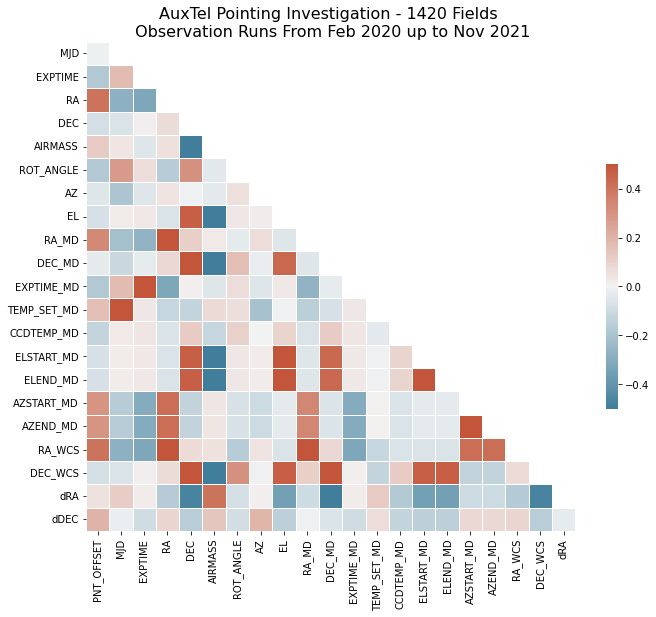

In [14]:
# Compute the correlation matrix
df_corr = df1.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df_corr, dtype=bool))

mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.5, vmin=-0.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title(f'AuxTel Pointing Investigation - {len(df1)} Fields \n Observation Runs From Feb 2020 up to Nov 2021',fontsize=16)
plt.savefig(f'figures/correlation_matrix_{date}.png',facecolor='w',transparent=False,dpi=100)

Text(0.5, 1.0, 'AuxTel Pointing Investigation - 1420 Fields \n Observation Runs From Feb 2020 up to Nov 2021')

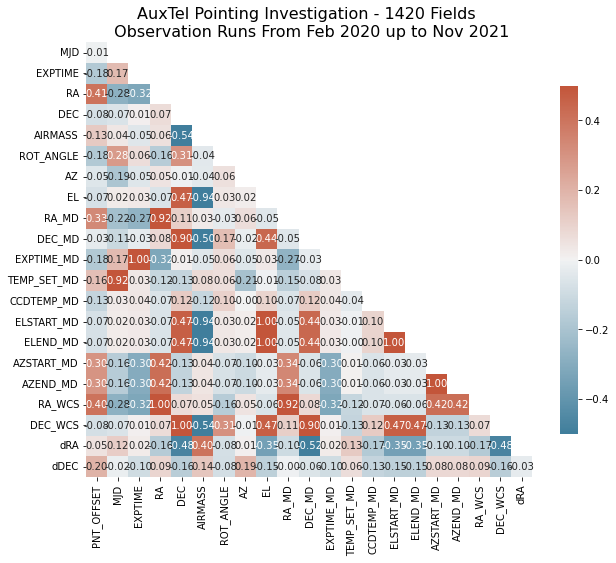

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))

df_corr = df1.corr()

# mask
mask = np.triu(np.ones_like(df_corr, dtype=bool))

# adjust mask and df
mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()

# plot heatmap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap=cmap,
           vmin=-0.5, vmax=0.5, cbar_kws={"shrink": .8})
# yticks
plt.yticks(rotation=0)
plt.title(f'AuxTel Pointing Investigation - {len(df1)} Fields \n Observation Runs From Feb 2020 up to Nov 2021',fontsize=16)

# plt.savefig(f'figures/correlation_matrix_{date}.png',facecolor='w',transparent=False,dpi=100)

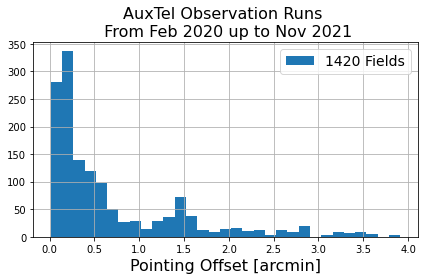

In [16]:
df1['PNT_OFFSET'].hist(bins=31,label=f'{len(df1)} Fields')
plt.xlabel('Pointing Offset [arcmin]',fontsize=16)
plt.legend(fontsize=14)
plt.title(f'AuxTel Observation Runs \n From Feb 2020 up to Nov 2021',fontsize=16)
plt.tight_layout()
plt.savefig(f'figures/pointing_offset_distribution_{date}.png',facecolor='w',transparent=False,dpi=100)

In [17]:
p1,pm,p2 = np.percentile(df1.PNT_OFFSET, [16,50,84])
s68 = (p2-p1)/2.
s68

0.6439107570307135

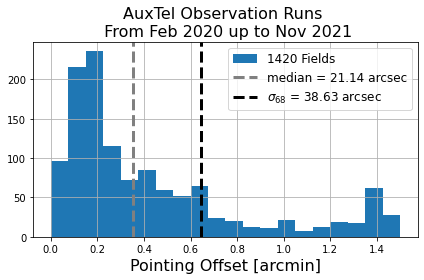

In [18]:
df1['PNT_OFFSET'].hist(bins=np.linspace(0.,1.5,21),label=f'{len(df1)} Fields')
plt.axvline(pm,color='gray',ls='--',lw=3, label=r'median = %.2f arcsec'%(pm*60))
plt.axvline(s68,color='k',ls='--',lw=3, label=r'$\sigma_{68}$ = %.2f arcsec'%(s68*60))

plt.xlabel('Pointing Offset [arcmin]',fontsize=16)
plt.legend(fontsize=12)
plt.title(f'AuxTel Observation Runs \n From Feb 2020 up to Nov 2021',fontsize=16)
plt.tight_layout()
plt.savefig(f'figures/pointing_offset_distribution_{date}_zoom_in.png',facecolor='w',transparent=False,dpi=100)

In [19]:
6.5/s68 ## fov / precision

10.09456656691629

In [20]:
0.2*60

12.0

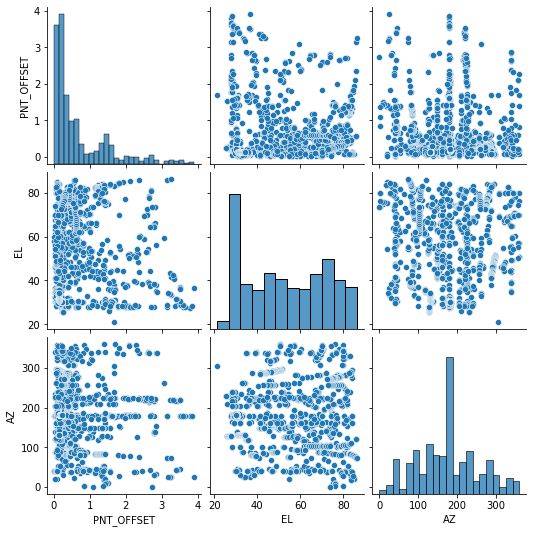

In [21]:
columns = ['PNT_OFFSET','EL','AZ']
sns.pairplot(df1[columns])

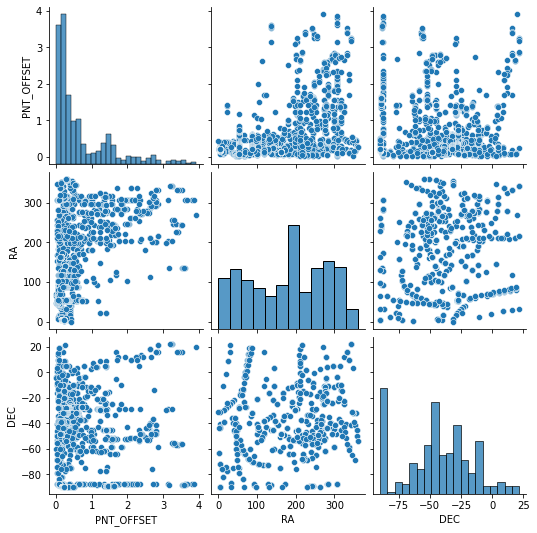

In [22]:
columns = ['PNT_OFFSET','RA','DEC']
sns.pairplot(df1[columns])

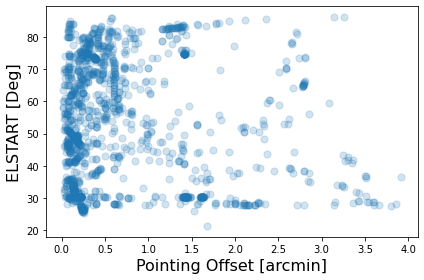

In [23]:
plt.scatter(df1.PNT_OFFSET, df1.EL, s=50, alpha=0.2)
plt.ylabel('ELSTART [Deg]',fontsize=16)
plt.xlabel('Pointing Offset [arcmin]',fontsize=16)
plt.tight_layout()
plt.savefig(f'figures/pointing_offset_elevation_{date}.png',facecolor='w',transparent=False,dpi=100)

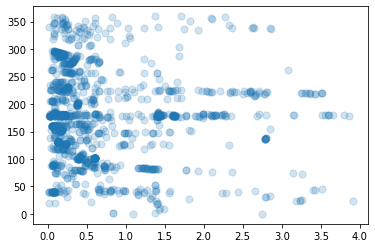

In [24]:
plt.scatter(df1.PNT_OFFSET, df1.AZ, s=50, alpha=0.2)

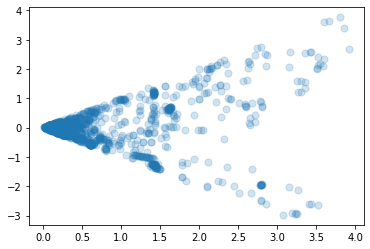

In [25]:
plt.scatter(df1.PNT_OFFSET, df1.dDEC, s=50, alpha=0.2)

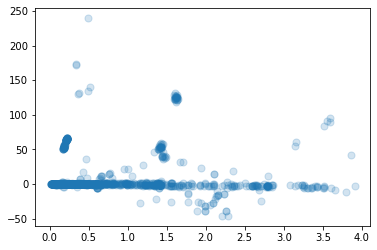

In [26]:
plt.scatter(df1.PNT_OFFSET, df1.dRA, s=50, alpha=0.2)


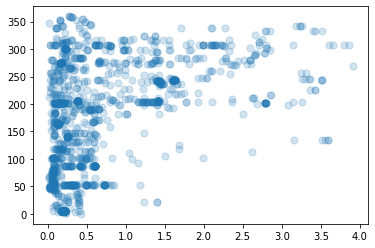

In [27]:
plt.scatter(df1.PNT_OFFSET, df1.RA, s=50, alpha=0.2)

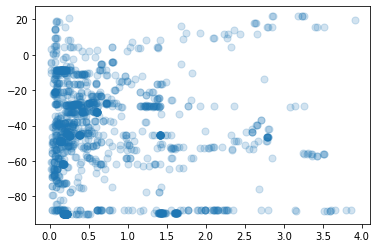

In [28]:
plt.scatter(df1.PNT_OFFSET, df1.DEC, s=50, alpha=0.2)

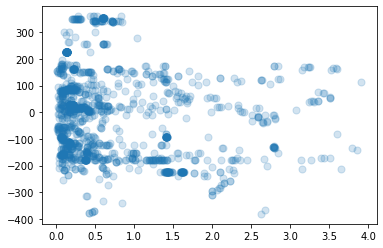

In [29]:
plt.scatter(df1.PNT_OFFSET, df1.ROT_ANGLE, s=50, alpha=0.2)


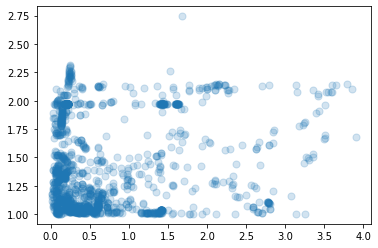

In [30]:
plt.scatter(df1.PNT_OFFSET, df1.AIRMASS, s=50, alpha=0.2)

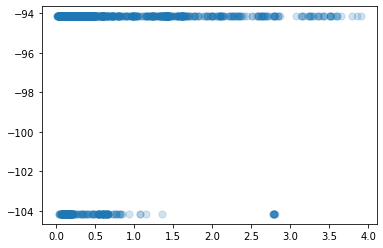

In [31]:
plt.scatter(df1.PNT_OFFSET, df1.TEMP_SET_MD, s=50, alpha=0.2)
# plt.ylim(-94.1501,-94.1497)
# plt.ylim(-104.1,-104.25)

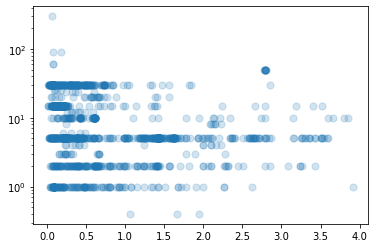

In [32]:
plt.scatter(df1.PNT_OFFSET, df1.EXPTIME, s=50, alpha=0.2)
plt.yscale('log')

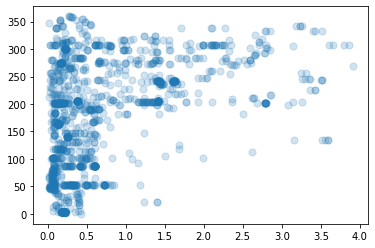

In [33]:
plt.scatter(df1.PNT_OFFSET, df1.RA_WCS, s=50, alpha=0.2)

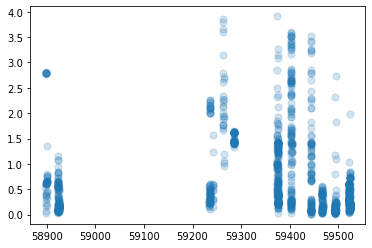

In [34]:
plt.scatter(df1.MJD, df1.PNT_OFFSET, s=50, alpha=0.2)
# plt.xlim(202102100,)
# plt.xscale('log')

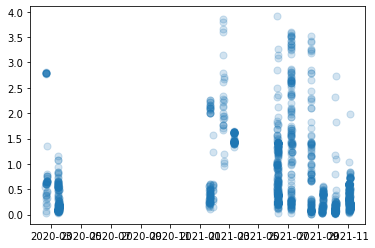

In [35]:
plt.scatter(df1.DATE.dt.date, df1.PNT_OFFSET, s=50, alpha=0.2)

## Checking MetaData Pointing

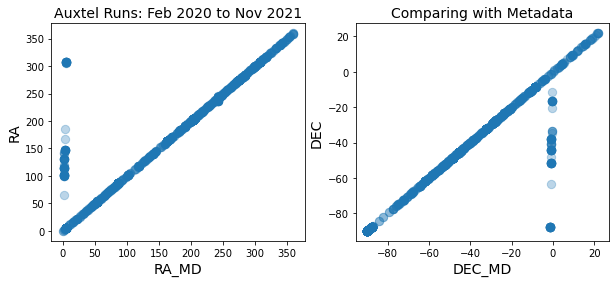

In [36]:
fig = plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
plt.scatter(df.RA_MD,df.RA, s=70, alpha=0.3)
plt.xlabel('RA_MD',fontsize=14)
plt.ylabel('RA',fontsize=14)
plt.title('Auxtel Runs: Feb 2020 to Nov 2021',fontsize=14)
plt.subplot(1, 2, 2)
plt.scatter(df.DEC_MD,df.DEC, s=70, alpha=0.3)
plt.xlabel('DEC_MD',fontsize=14)
plt.ylabel('DEC',fontsize=14)
plt.title('Comparing with Metadata', fontsize=14)

plt.savefig(f'figures/comparing_metadata_pointing_{date}.png',facecolor='w',transparent=False,dpi=100)

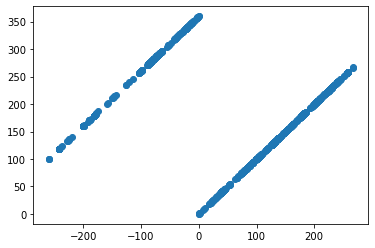

In [37]:
plt.scatter(df.AZSTART_MD,df.AZ)

## Checking Old Method

In [38]:
date = 23032022
df2 = pd.read_csv(f'data/checking_auxtel_pointing_{date}.csv',index_col=0)

df2['dRA'] = (df2['RA_WCS']-df2['RA'])*60
df2['dDEC']= (df2['DEC_WCS']-df2['DEC'])*60

df2['PNT_OFFSET'] = getAngDist(df2['RA_WCS'], df2['DEC_WCS'], df2['RA'], df2['DEC'])

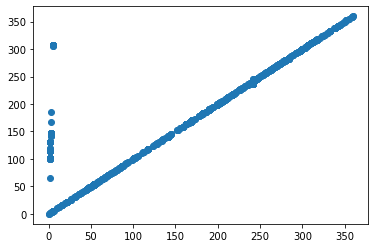

In [39]:
plt.scatter(df2.RA,df.RA)

(-6.0, 6.0)

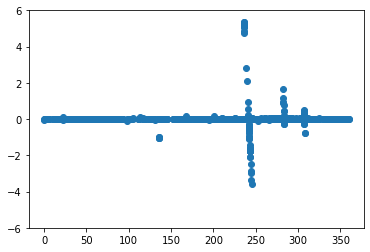

In [40]:
plt.scatter(df.RA,df2.RA-df.RA)
plt.ylim(-6.,6.)

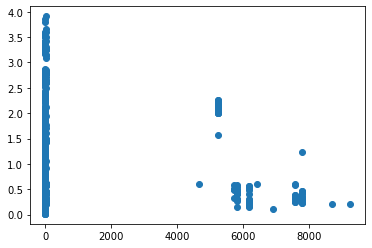

In [41]:
plt.scatter(df2.PNT_OFFSET,df.PNT_OFFSET)

In [42]:
outliers = np.abs(df2['PNT_OFFSET'])>60
# outliers = np.abs(df.RA-df.RA_MD)>1.
# outliers = np.abs(df2.RA-df.RA)>1.

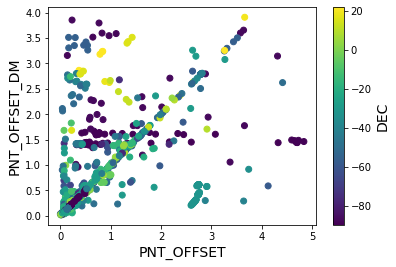

In [43]:
plt.scatter(df2.PNT_OFFSET[~outliers],df.PNT_OFFSET[~outliers], c=df.DEC[~outliers])
plt.colorbar().set_label('DEC',fontsize=14)
plt.ylabel('PNT_OFFSET_DM',fontsize=14)
plt.xlabel('PNT_OFFSET',fontsize=14)
plt.savefig(f'figures/comparing_version_pointing_offset_{date}.png',facecolor='w',transparent=False,dpi=100)

From now on I should use the `PNT_OFFSET` generated by the wcs soultions from the DM stack pipeline.